<a href="https://colab.research.google.com/github/rrankawat/pytorch-cnn-mnist/blob/main/CNN_Mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [46]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [47]:
# Train & Test Data
train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

In [48]:
# Grab 1 MNIST record/image
# enumerate: To get index and record
for i, (X_train, y_train) in enumerate(train_data):
    break

X_train.shape

torch.Size([1, 28, 28])

In [49]:
# Create a small batch size for images... let's say 10
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

In [50]:
for images, labels in train_loader:
  print(images.shape, labels.shape)
  break

torch.Size([10, 1, 28, 28]) torch.Size([10])


In [51]:
# Define our CNN Model
# Describe convolutional layer and what's it's doing (2 convolutional layers)
conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3, stride=1)
conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3, stride=1)

In [52]:
# Perform our first convolution
x = F.relu(conv1(X_train.view(1, 1, 28, 28)))
x.shape # 26 / 2

torch.Size([1, 6, 26, 26])

In [53]:
# Pass through the pooling layer
x = F.max_pool2d(x, 2, 2)
x.shape

torch.Size([1, 6, 13, 13])

In [54]:
# Second convolutional layer
x = F.relu(conv2(x))
x.shape

torch.Size([1, 16, 11, 11])

In [55]:
# Pass through the pooling layer
x = F.max_pool2d(x, 2, 2)
x.shape

torch.Size([1, 16, 5, 5])

In [56]:
# Model class
class ConvolutionalNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 6, 3, 1)
    self.conv2 = nn.Conv2d(6, 16, 3, 1)
    self.fc1 = nn.Linear(5 * 5 * 16, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

  def forward(self, X):
    # First Pass
    X = F.relu(self.conv1(X))
    X = F.max_pool2d(X, 2, 2)
    # Second Pass
    X = F.relu(self.conv2(X))
    X = F.max_pool2d(X, 2, 2)

    # Re-view to flatten it out
    X = X.view(-1, 16 * 5 * 5) # -1 so that we can vary the batch size

    # Fully Connected Layers
    X = F.relu(self.fc1(X))
    X = F.relu(self.fc2(X))
    X = self.fc3(X)

    return F.log_softmax(X, dim=1)

In [57]:
# Create an instance of our Model
torch.manual_seed(41) # To same initial weights every time
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [58]:
# Loss function optimizer

# Measures the difference between the model’s predicted probabilities and the true class labels.
criterion = nn.CrossEntropyLoss()

# Updates the model’s weights based on gradients computed from the loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [59]:
import time
start_time = time.time()

# Variables to track things
epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

# Loop through the epochs
for i in range(epochs):
  trn_corr = 0
  tst_corr = 0

  # Train
  for b, (X_train, y_train) in enumerate(train_loader):
    b += 1 # start the batches at 1
    y_pred = model(X_train)
    loss = criterion(y_pred, y_train) # predicted labels vs training data actual labels
    predicted = torch.max(y_pred.data, 1)[1] # Number of correct predictions
    batch_corr = (predicted == y_train).sum() # Correct from a batch
    trn_corr += batch_corr

    # Update parameters
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print out results
    if b%600 == 0:
      print(f'Epoch: {i} Batch: {b} Loss: {loss.item()}')

  train_losses.append(loss)
  train_correct.append(trn_corr)

  # Test
  with torch.no_grad(): # To not update our weights and biases with our test data
    for b, (X_test, y_test) in enumerate(test_loader):
      y_val = model(X_test)
      predicted = torch.max(y_val.data, 1)[1]
      tst_corr += (predicted == y_test).sum()

  loss = criterion(y_val, y_test)
  test_losses.append(loss)
  test_correct.append(tst_corr)


current_time = time.time()
total_time = current_time - start_time
print(f'Training took: {total_time/60} minutes!')

Epoch: 0 Batch: 600 Loss: 0.1623610556125641
Epoch: 0 Batch: 1200 Loss: 0.1502392590045929
Epoch: 0 Batch: 1800 Loss: 0.4744560718536377
Epoch: 0 Batch: 2400 Loss: 0.14238706231117249
Epoch: 0 Batch: 3000 Loss: 0.007758188061416149
Epoch: 0 Batch: 3600 Loss: 0.3836284875869751
Epoch: 0 Batch: 4200 Loss: 0.0038223876617848873
Epoch: 0 Batch: 4800 Loss: 0.0021286322735249996
Epoch: 0 Batch: 5400 Loss: 0.0569545142352581
Epoch: 0 Batch: 6000 Loss: 0.00038789428072050214
Epoch: 1 Batch: 600 Loss: 0.005851339548826218
Epoch: 1 Batch: 1200 Loss: 0.3855525553226471
Epoch: 1 Batch: 1800 Loss: 0.004819948226213455
Epoch: 1 Batch: 2400 Loss: 0.003216963727027178
Epoch: 1 Batch: 3000 Loss: 0.0332382395863533
Epoch: 1 Batch: 3600 Loss: 0.5372857451438904
Epoch: 1 Batch: 4200 Loss: 0.04561494290828705
Epoch: 1 Batch: 4800 Loss: 0.0007510822033509612
Epoch: 1 Batch: 5400 Loss: 0.0001173773780465126
Epoch: 1 Batch: 6000 Loss: 0.14201366901397705
Epoch: 2 Batch: 600 Loss: 0.023733172565698624
Epoch: 2

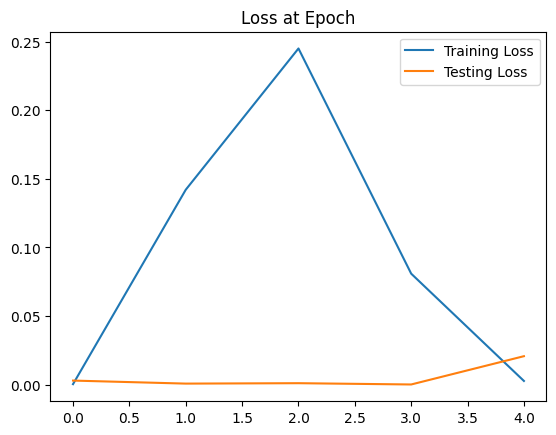

In [60]:
# Plot the loss at epoch
plt.plot([loss.detach().numpy() for loss in train_losses], label='Training Loss')
plt.plot([loss.detach().numpy() for loss in test_losses], label='Testing Loss')
plt.title('Loss at Epoch')
plt.legend()

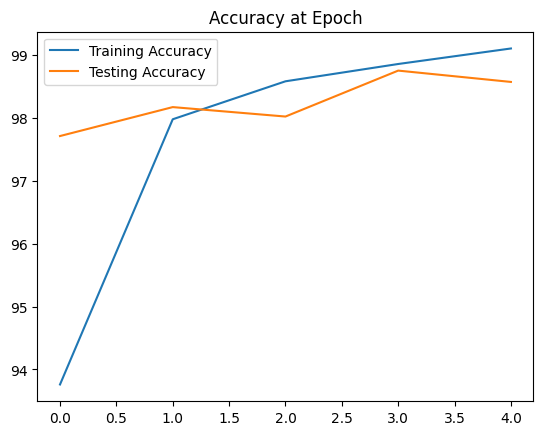

In [61]:
# Plot the accuracy at the end of each epoch
plt.plot([t/600 for t in train_correct], label='Training Accuracy')
plt.plot([t/100 for t in test_correct], label='Testing Accuracy')
plt.title('Accuracy at Epoch')
plt.legend()

In [62]:
test_load_everything = DataLoader(test_data, batch_size=10000, shuffle=False)

In [63]:
with torch.no_grad():
  correct = 0
  for X_test, y_test in test_load_everything:
    y_val = model(X_test)
    predicted = torch.max(y_val, 1)[1]
    correct += (predicted == y_test).sum()

In [64]:
# Test for correct
correct.item()/len(test_data)*100

98.57000000000001

In [65]:
# Grab an image
# test_data[4146] # Tensor with an image in it... at end, it shows the label

In [66]:
# Grab just the data
# test_data[4143][0]

In [67]:
# Reshape it
# test_data[4143][0].reshape(28, 28)

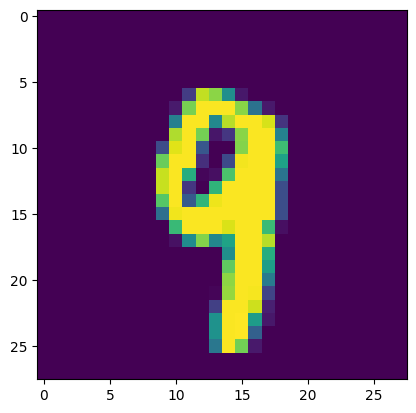

In [68]:
# Show the image
plt.imshow(test_data[4143][0].reshape(28, 28))

In [69]:
# Pass the image thru our model
model.eval()
with torch.no_grad():
  new_prediction = model(test_data[4143][0].view(1, 1, 28, 28)) # batch of 1, 1 color channel, 28x28 image

In [70]:
# Check the new prediction
# new_prediction

In [71]:
new_prediction.argmax()

tensor(9)